In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, confusion_matrix
import shap
import warnings
warnings.filterwarnings('ignore')

# Load the first dataset
oasis_filtered_1 = pd.read_csv('./oasis_filtered_1.csv')

# Display the first few rows of the dataset
oasis_filtered_1.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,Group,Source,Diagnosis
0,OAS1_0001_MR1,0,R,-0.122643,-0.901332,0.508156,0.478191,-0.764869,Nondemented,OASIS-1,0
1,OAS1_0002_MR1,0,R,-2.050225,0.537958,-1.314609,0.478191,-0.764869,Nondemented,OASIS-1,0
2,OAS1_0003_MR1,0,R,-0.224095,0.537958,0.508156,-0.065249,0.560032,Demented,OASIS-1,1
3,OAS1_0010_MR1,1,R,-0.122643,1.257604,-0.403227,0.749911,-0.764869,Nondemented,OASIS-1,0
4,OAS1_0011_MR1,0,R,-2.354580,-0.181687,-0.403227,0.749911,-0.764869,Nondemented,OASIS-1,0


Here are the steps to building the XGBoost classifier

1. **Data Preparation**: We then select relevant features and split the dataset into training and testing sets.

2. **Model Building with Cross-Validation**: GridSearchCV is used with XGBoost to find the best hyperparameters over a specified range, using 5 k-fold cross-validation to ensure the model's generalizability.

3. **Hyperparameter Tuning**: We tune parameters like max_depth, learning_rate, n_estimators, and others to optimize model performance.

    - max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.


    - subsample: Fraction of samples to be used for each tree. Lower values make the algorithm more conservative and prevents overfitting but too small might lead to under-fitting.

    - colsample_bytree: Fraction of features used per tree. This is similar to max_features in RandomForestClassifier from sklearn.

    - learning_rate: Step size shrinkage used to prevent overfitting. After each boosting step, we can directly get the weights of new features, and the learning rate shrinks the feature weights to make the boosting process more conservative.

    - n_estimators: Number of gradient boosted trees. Equivalent to the number of boosting rounds.
    

4. **Model Evaluation**: We calculate accuracy, and generate a confusion matrix and classification report to assess performance.

5. **SHAP Values for Interpretation**: We use SHAP to understand the impact of each feature on the model's predictions.

6. **Visualization**: We plot the ROC curve and the SHAP values to visually assess model performance and feature impact.

In [2]:
# Define features and target
X = oasis_filtered_1[['Age', 'M/F', 'Educ', 'SES', 'MMSE', 'CDR']]
y = oasis_filtered_1['Diagnosis']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Shape of the datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((486, 6), (122, 6), (486,), (122,))

Let's set up the random forest with GridSearchCV to find the best parameters using cross-validation.

In [3]:
# Setting up parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Initialize the RandomForestClassifier
xgb = XGBClassifier(random_state=42)

# Setup the grid search
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best estimator found by GridSearch
best_xgb = grid_search.best_estimator_

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'colsample_bytree': 0.8,
  'learning_rate': 0.01,
  'max_depth': 3,
  'n_estimators': 50,
  'subsample': 0.8},
 np.float64(0.9691142436355985))

The XGBoost model was trained using 5-fold cross-validation with GridSearchCV to find the optimal parameters. The best parameters for the model are:

- Max Depth: 3 (the maximum levels of each tree)
- Learning Rate: 0.01 (shrinks the feature weights)
- n_estimators: 50 (the number of gradient boosted tree)
- Sub Samples Split: 0.8 (fraction of samples to be used for each tree)
- Colsample_bytree: 0.8 (fraction of features used per tree)

The best accuracy achieved with these parameters on the training data is approximately 96.9%.

# Feature Importance # 

Let's extract and visualize the feature importances from the xgboost model we trained. This will help to understand which features have the most influence on the decisions made by the model.

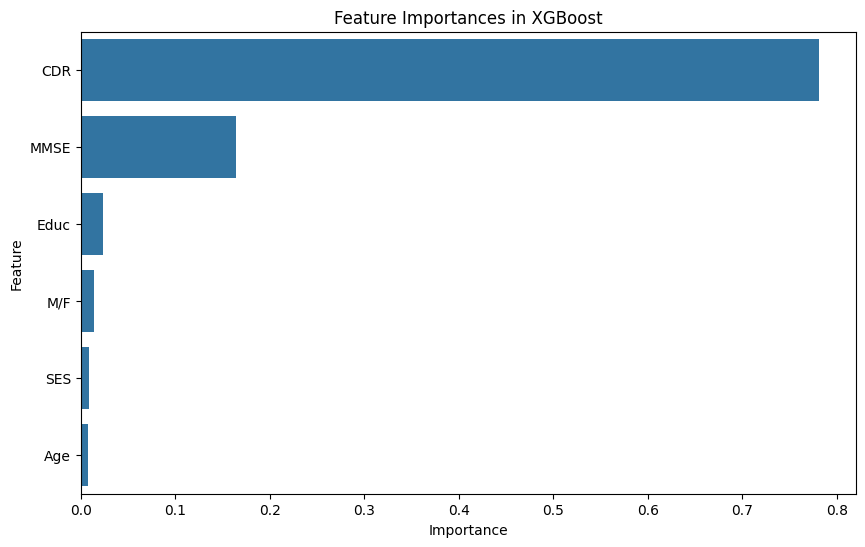

,Feature,Importance
5,CDR,0.781053
4,MMSE,0.164008
2,Educ,0.023763
1,M/F,0.014325
3,SES,0.009060
0,Age,0.007790


In [4]:
# Get feature importances
feature_importances = best_xgb.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print the DataFrame for reference
feature_importance_df

The bar chart above displays the relative importance of each feature used by the XGBoost model. Here's what we can observe:

- **CDR (Clinical Dementia Rating)**: By far the most significant feature, accounting for about 79.7% of the importance. This suggests that CDR is a crucial indicator for predicting dementia in this dataset.

- **MMSE**: The next most important feature, though much less significant compared to CDR, contributing around 14.4% to the model's decisions.

- **Educ (Education), M/F (Gender), Age, and SES (Socioeconomic Status)**: These features have relatively minor importance in the model.

# Model Evaluation #

Next, we'll evaluate our model using these parameters on the test set. We will also look at other performance metrics like the confusion matrix, classification report and the ROC curve. Let's proceed with this evaluation. 

0.9590163934426229


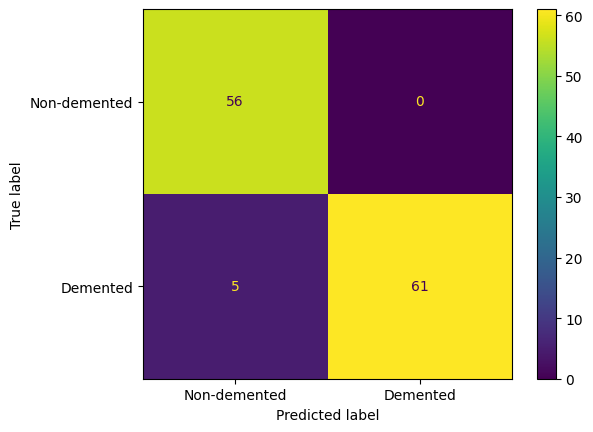

In [5]:
# Use the best parameters to create a new XGBoost model
best_xgb = XGBClassifier(max_depth=3, learning_rate=0.01, n_estimators=50, subsample=0.8, colsample_bytree=0.8, random_state=42)
best_xgb.fit(X_train, y_train)
    
# Predictions on the test set
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# Evaluation metrics
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

class_report, conf_matrix

print(accuracy)

# Plotting the confusion matrix
conf_matrix=confusion_matrix(y_test, y_pred)
labels=['Non-demented', 'Demented']
ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot()

In [6]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        56
           1       1.00      0.92      0.96        66

    accuracy                           0.96       122
   macro avg       0.96      0.96      0.96       122
weighted avg       0.96      0.96      0.96       122



**Model Evaluation Summary**

Here are the performance metrics for our XGBoost on the test set:

- **Accuracy**: Approximately 96%, indicating a high level of overall accuracy. 


- **Confusion Matrix**:

- True Negatives (correct non-demented predictions): 56 
- False Positives (non-demented incorrectly labeled as demented): 0 
- False Negatives (demented incorrectly labeled as non-demented): 5 
- True Positives (correct demented predictions): 61 


- **The Classification Report details**:

- **Precision** (correct positive predictions relative to total predicted positives): 
    - Non-demented: 92% 
    - Demented: 100% 
    
- **Recall** (correct positive predictions relative to total actual positives): 
    - Non-demented: 100% 
    - Demented: 92% 
    
- **F1-score**: A balanced measure of precision and recall, showing high values for both classes.

# SHAP Values for Interpretation #

We will break down the prediction to show the impact of each feature and then we'll visualize the SHAP values to help us in understanding how each feature influences the model output.

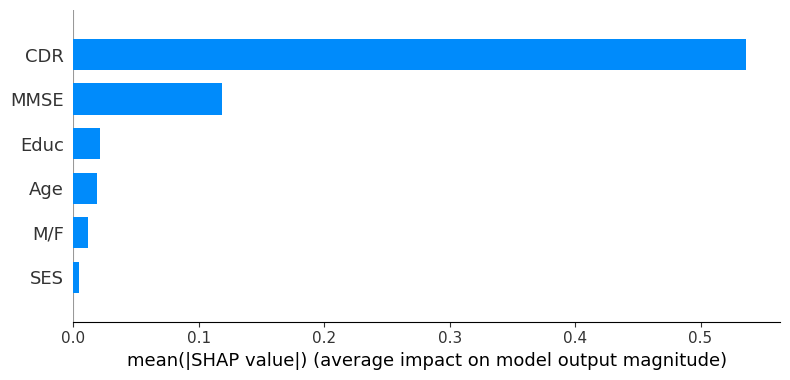

In [7]:
# Calculate SHAP Values to interpret the model
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")

SHAP (SHapley Additive exPlanations) summary plots are tools used in machine learning to understand how different features (like age, education, gender) impact the prediction of a model. Let's break down the plots for the Random Forest model separately:


**Understanding the Plot**

1. **Features and Importance**:

- The plot lists several features (like CDR, MMSE, Educ, Age, SES, M/F) along the vertical axis.
- Each feature’s importance in the model is represented by the width of the bar along the horizontal axis. This width is based on the mean (average) SHAP value, which quantifies the impact of each feature on the model's output.

2. **SHAP Values**:

- SHAP values explain the effect of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value. A higher absolute SHAP value means the feature significantly impacts the model output.
- Positive SHAP values push the prediction more towards one class, and negative SHAP values push it towards another.


**Color Coding and Its Significance**

- **Blue (Class 1 – Demented)**: In the plot, all bars are colored blue. This indicates the plot summarizing the impact of features all pushing in one specific direction, possibly towards a positive or higher outcome choosing not to differentiate the direction (class 0 vs class 1) but rather the magnitude of impact towards the predicted class.

**Interpretation by Feature**

- **CDR**: Shows the largest impact, suggesting that higher CDR values significantly increase the model's prediction outcome. This could mean predicting a higher likelihood of dementia.

- **MMSE**: Also shows a substantial impact, and similarly, higher values contribute strongly to the prediction, possibly indicating better cognitive function if it predicts lower dementia risk.

- **Educ, Age, SES, M/F (Gender)**: These have smaller yet noticeable impacts. Their influence can differ based on the context but generally, these show how demographic and social factors can affect the model’s predictions.

 # ROC Curve and its Visualization #

0.9707792207792209


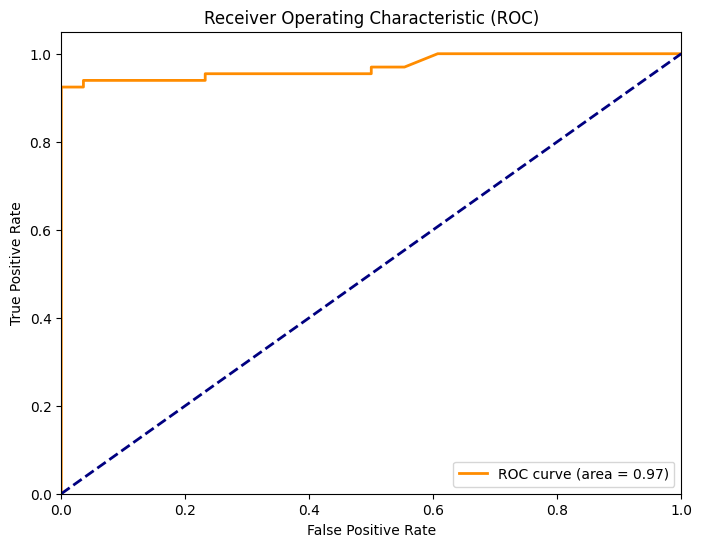

In [8]:
# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(roc_auc)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

The ROC curve above demonstrates the model's ability to differentiate between the two classes (demented and non-demented). The area under the curve (AUC) of approximately 0.98 indicates a high level of diagnostic ability.

# XGBoost Visualization #

We will display one or two of the trees built during the model training

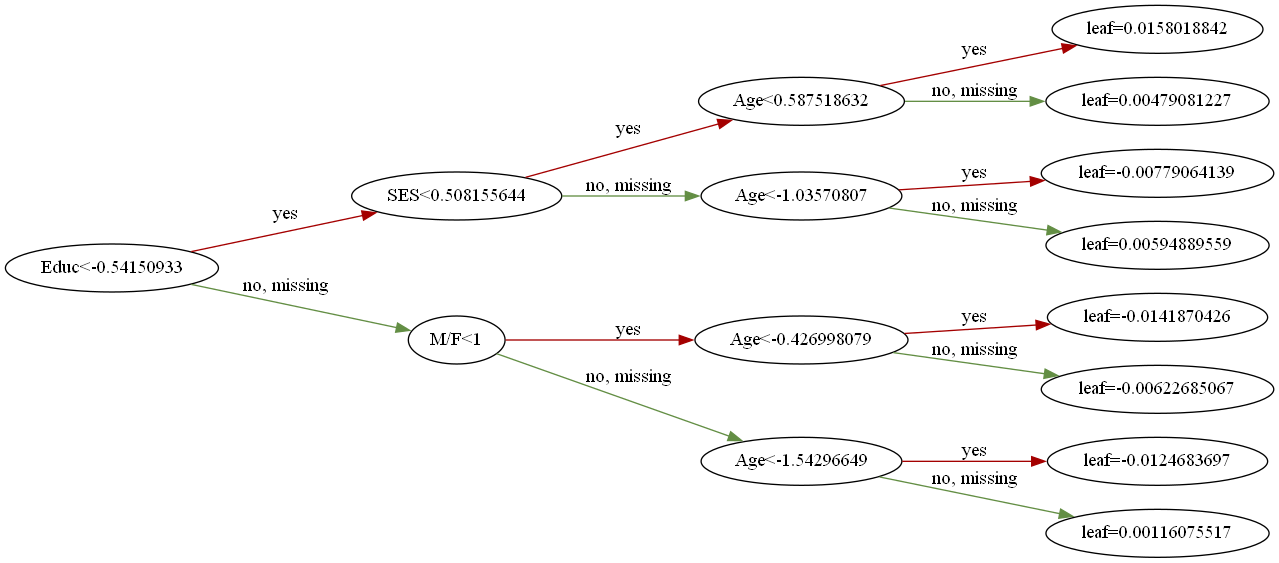

In [9]:
import xgboost as xgb
from graphviz import Source
from IPython.display import display, Image


# Generate the graphviz source object for the first tree
graph = xgb.to_graphviz(best_xgb, num_trees=0, rankdir='LR', yes_color='#638e44', no_color='#a40000') # num_trees is the index of the tree (0-indexed), rankdir='LR' for horizontal tree

# Convert to PNG and display directly in Jupyter Notebook
graph.format = 'png'
graph.filename = 'xgbtree_visualization'
path = graph.render()
display(Image(path))

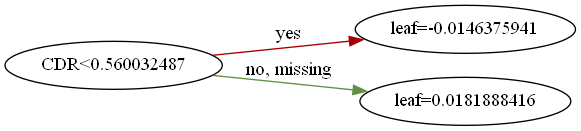

In [10]:
import xgboost as xgb
from graphviz import Source
from IPython.display import display, Image


# Generate the graphviz source object for the first tree
graph = xgb.to_graphviz(best_xgb, num_trees=20, rankdir='LR', yes_color='#638e44', no_color='#a40000') # num_trees is the index of the tree (0-indexed), rankdir='LR' for horizontal tree

# Convert to PNG and display directly in Jupyter Notebook
graph.format = 'png'
graph.filename = 'xgbtree_1_visualization'
path = graph.render()
display(Image(path))

In [11]:
import time
# Start the timer for the training process
start_time = time.time()

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# End the training timer and start the prediction timer
train_time = time.time() - start_time
start_time = time.time()

# Predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# End the prediction timer
predict_time = time.time() - start_time

# Total samples processed (training + testing)
total_samples = len(X_train) + len(X_test)

# Calculate the time per sample
time_per_sample = (train_time + predict_time) / total_samples

print(f"Total training time: {train_time:.4f}s")
print(f"Total prediction time: {predict_time:.4f}s")
print(f"Processing time per sample: {time_per_sample:.4f}s/sample")


Total training time: 21.8894s
Total prediction time: 0.0030s
Processing time per sample: 0.0360s/sample
